In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import defaultdict
import seaborn as sns
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Reading the training and test datasets

In [ ]:
df_train = pd.read_csv("/content/gdrive/MyDrive/EDA/data/Corona_NLP_train.csv", encoding="latin_1")
df_test = pd.read_csv("/content/gdrive/MyDrive/EDA/data/Corona_NLP_test.csv", encoding="latin_1")
df=pd.concat([df_train,df_test])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [ ]:
#size of the training and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Test set shape {df_test.shape}')

Training set shape: (41157, 6)
Test set shape (3798, 6)


Drop duplicates from the dataset.
There are no duplicates in the dataset.

In [ ]:
df_train.drop_duplicates()
df_test.drop_duplicates()
print(f'Training set shape after removing duplicates: {df_train.shape}')
print(f'Test set shape after removing duplicates:  {df_test.shape}')

Training set shape after removing duplicates: (41157, 6)
Test set shape after removing duplicates:  (3798, 6)


Check for missing values for column Location.

In [ ]:
bool_series_train = pd.isnull(df_train["Location"]) 
bool_series_test = pd.isnull(df_test["Location"]) 

print(f'Location missing values for train dataset: {df_train[bool_series_train].shape}')
print(f'Location missing values for test dataset: {df_test[bool_series_test].shape}')

Location missing values for train dataset: (8590, 6)
Location missing values for test dataset: (834, 6)


Total number of Tweets for each sentiment.

In [ ]:
print(df_train['Sentiment'].unique())
df_train['Sentiment'].value_counts()

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Define class color code: blue - negative, green - positive, yellow - neutral


In [ ]:
SENT_TO_COLOR = {
    'Positive':'#008000',
    'Negative':'#0000FF',
    'Neutral':'#FF8C00'
}

Plot piechart for polarity category percentages

In [ ]:
#plot percentage of each class
#we also printed the unique classes and number of tweets per class
#it is obvious that the dataset is quite unbalanced
#the percentages of positive and negative tweets are double as the neutral ones
def get_percentage_classes(df, cat_classes=5):

  def classes_def(x):
    if x ==  "Extremely Positive":
        return "Positive"
    elif x == "Extremely Negative":
        return "Negative"
    else:
      return x
  
  my_df = df.copy()
  if cat_classes == 3:
    my_df['Sentiment'] = my_df['Sentiment'].apply(lambda x:classes_def(x))

  print(f"Unique Class names: {my_df['Sentiment'].unique()}")
  print(f"Total number of tweets per class: \n {my_df['Sentiment'].value_counts()}")

  classes = np.unique(my_df['Sentiment'])
  d = dict.fromkeys(classes, 0)
  for cat_class in my_df['Sentiment']:
    d[cat_class] += 1
  

  y = d.values()
  labels  = d.keys()

  plt.pie(y, labels = labels, radius = 1.2,autopct="%.1f%%")
  plt.show() 


Unique Class names: ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Total number of tweets per class: 
 Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


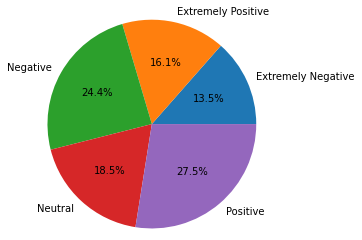

In [ ]:
#Piechart when polarity category are: extremely negative, negative, neutral, positive, extremely positive
get_percentage_classes(df,5)

Unique Class names: ['Neutral' 'Positive' 'Negative']
Total number of tweets per class: 
 Positive    19592
Negative    17031
Neutral      8332
Name: Sentiment, dtype: int64


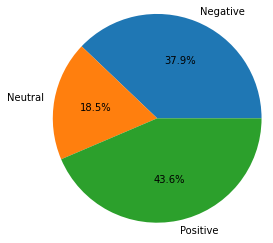

In [ ]:
#Piechart when polarity category are: negative, neutral, positive
get_percentage_classes(df,3)

#Tweet tokens exploration

Firstly, one could make the case that the classes at the extremes of the spectrum, namely Extremely Negative and Extremely Positive could be generally assumed to be Negative and Positive reactions respectively. Thus, we can reduce the number of distinct sentiments from 5 to 3.

In [ ]:
def reduce_sentiment(x):
  return x.split()[1] if x.startswith('Extremely') else x

df_train['sentiment_code'] = df_train['Sentiment'].apply(reduce_sentiment)
df_test['sentiment_code'] = df_test['Sentiment'].apply(reduce_sentiment)


In [ ]:
#training set
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment_code
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Negative


In [ ]:
#test set
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment_code
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,Neutral


 ## Punctuations
Another interesting feature of tweet text we explored was the number of special characters. As the above bar plots show, tweet texts include a lot of usual punctuation marks such as period, comma, question mark, apostrophe etc. At the same time, there are some uncommon punctuation such as: slash (/) and hash (#) that can indicate that tweets contain hyperlinks and hashtags, features explored below.


In [ ]:
special = string.punctuation

def special_punctations(df, name_df):

  special = string.punctuation

  def aux_special_punctations(df, label):
    dic=defaultdict(int)
    for _, row in df.iterrows():
      text = row['OriginalTweet']
      sentiment = row['Sentiment']
      if sentiment == label:
        for ch in text:
          if ch in special:
            dic[ch] += 1
    
    return dic
  

  print("\n" + name_df + "\n")

  dic_pos = aux_special_punctations(df, 'Positive')
  x,y=zip(*dic_pos.items())
  x_aux = []
  y_aux = []
  for i in range(len(x)):
    if y[i] > 100:
      x_aux.append(x[i])
      y_aux.append(y[i])
  plt.figure(figsize=(8,3))
  plt.title('Positive Sentiments')
  plt.bar(x_aux,y_aux,color=SENT_TO_COLOR['Positive'])

  dic_neg = aux_special_punctations(df, 'Negative')
  x,y=zip(*dic_neg.items())
  x_aux = []
  y_aux = []
  for i in range(len(x)):
    if y[i] > 100:
      x_aux.append(x[i])
      y_aux.append(y[i])
  plt.figure(figsize=(8,3))
  plt.title('Negative Sentiments')
  plt.bar(x_aux,y_aux,color=SENT_TO_COLOR['Negative'])

  dic_neu = aux_special_punctations(df, 'Neutral')
  x,y=zip(*dic_neu.items())
  x_aux = []
  y_aux = []
  for i in range(len(x)):
    if y[i] > 100:
      x_aux.append(x[i])
      y_aux.append(y[i])
  plt.figure(figsize=(8,3))
  plt.title('Neutral Sentiments')
  plt.bar(x_aux,y_aux,color=SENT_TO_COLOR['Neutral'])





Train



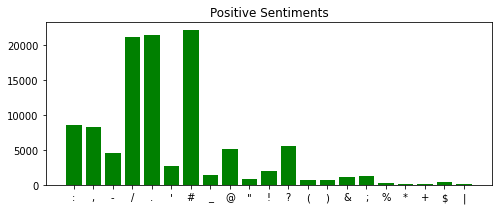

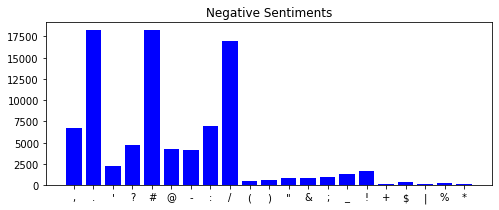

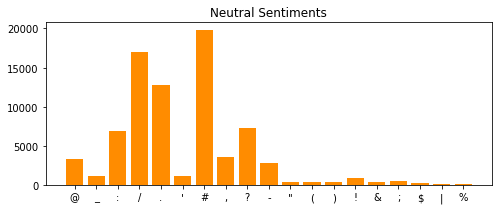

In [ ]:
special_punctations(df_train, "Train")



Test



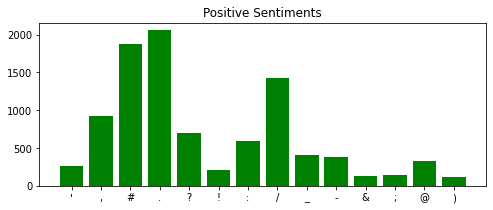

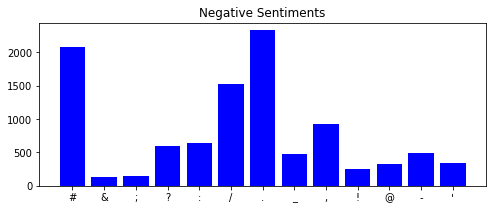

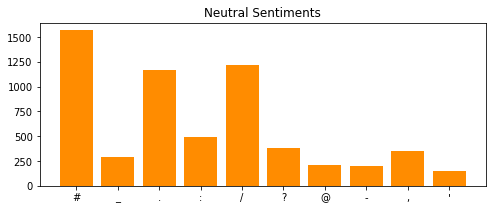

In [ ]:
special_punctations(df_test, "Test")

##Total URLS for each sentiment
We wanted to explore the number of hyperlinks of each class for training and dataset and noticed that the positive tweets contain a large number of hyperlinks, being followed by negative tweets.

Sentiment
Negative     7930
Neutral      5528
Positive    10397
Name: TotalLinks, dtype: int64


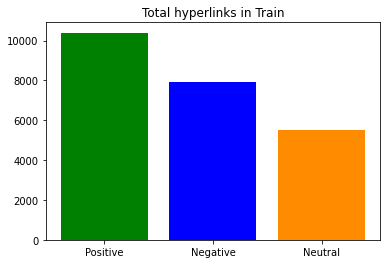

Sentiment
Negative    689
Neutral     390
Positive    739
Name: TotalLinks, dtype: int64


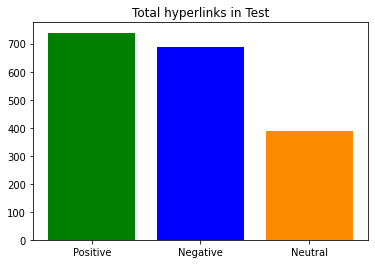

In [ ]:
def average_link_per_class(df, title):
  
  def get_total_links(x: str):
    return len([link for link in x.split() if link.startswith('http')])
  
  df2 = df
  df2['Sentiment'] = df2['Sentiment'].apply(lambda x: x.split()[1] if x.startswith('Extremely') else x)
  
  labels = ['Positive', 'Negative', 'Neutral']
  df2['TotalLinks'] = df2['OriginalTweet'].apply(get_total_links)
  total_per_class = df2.groupby('Sentiment')['TotalLinks'].sum()
  print(total_per_class)
  X = np.arange(total_per_class.shape[0])
  plt.bar(labels,[total_per_class[label] for label in labels], color = [SENT_TO_COLOR[label] for label in labels])
  plt.title(title)
  plt.show()


average_link_per_class(df_train, "Total hyperlinks in Train")
average_link_per_class(df_test, "Total hyperlinks in Test")


##Total Tags for each sentiment
We wanted to explore the number of hashtags of each class for training and dataset and noticed that the positive tweets contain a large number of hashtags, being followed by negative tweets.

Sentiment
Negative    26781
Neutral     19662
Positive    34441
Name: TotalTags, dtype: int64


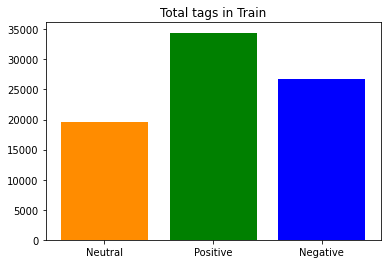

Sentiment
Negative    3174
Neutral     1557
Positive    3069
Name: TotalTags, dtype: int64


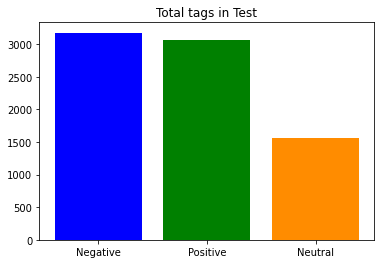

In [ ]:
def total_tags_per_class(df, title):
  
  def get_total_tags(x: str):
    return len([link for link in x.split() if link.startswith('#')])
  
  df2 = df
  df2['Sentiment'] = df2['Sentiment'].apply(lambda x: x.split()[1] if x.startswith('Extremely') else x)
  
  labels = df2['Sentiment'].unique()

  df2['TotalTags'] = df2['OriginalTweet'].apply(get_total_tags)
  total_per_class = df2.groupby('Sentiment')['TotalTags'].sum()
  print(total_per_class)
  X = np.arange(total_per_class.shape[0])
  plt.bar(labels, [total_per_class[label] for label in labels], color = [SENT_TO_COLOR[label] for label in labels])
  plt.title(title)
  plt.show()


total_tags_per_class(df_train, "Total tags in Train")
total_tags_per_class(df_test, "Total tags in Test")

## Number of words in a tweet

We ploted the number of words histograms per each sentiment. It is noticeable that the positive sentiment histogram and the negative sentiment histogram looks aprox. the same, having a large number of tweets between 30 and 45 words, while the neutral sentiments histogram has a large number of tweets between 10 and 25 words.


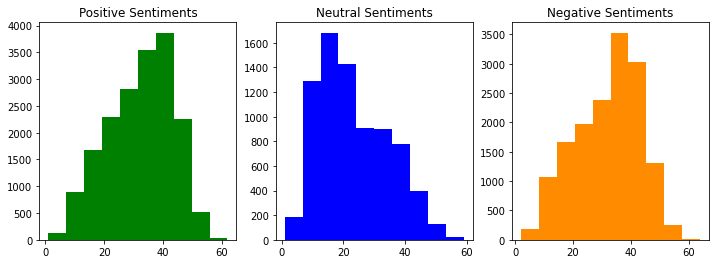

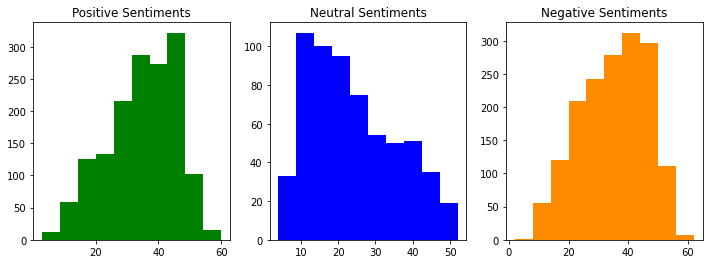

In [ ]:
def number_words(df):
  def classes_def(x):
    if x ==  "Extremely Positive":
        return "Positive"
    elif x == "Extremely Negative":
        return "Negative"
    else:
      return x
  
  my_df = df
  my_df['Sentiment'] = df['Sentiment'].apply(lambda x:classes_def(x))

  #get positive tweets length
  tweet_positive = df[df['Sentiment']=="Positive"]['OriginalTweet']
  tweet_positive = tweet_positive.str.split().map(lambda x: len(x))
  #get neutral tweets length
  tweet_neutral = df[df['Sentiment']=="Neutral"]['OriginalTweet']
  tweet_neutral = tweet_neutral.str.split().map(lambda x: len(x))
  #get neutral tweets length
  tweet_negative = df[df['Sentiment']=="Negative"]['OriginalTweet']
  tweet_negative = tweet_negative.str.split().map(lambda x: len(x))

  fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

  ax1.hist(tweet_positive,color=SENT_TO_COLOR['Positive'], density=False)
  ax1.set_title('Positive Sentiments')

  ax2.hist(tweet_neutral,color=SENT_TO_COLOR['Negative'], density=False)
  ax2.set_title('Neutral Sentiments')

  ax3.hist(tweet_negative,color=SENT_TO_COLOR['Neutral'], density=False)
  ax3.set_title('Negative Sentiments')

  plt.show()

number_words(df_train)
number_words(df_test)

##Average word length for each sentiment
Both the training and testing datasets show that the average word length for the Positive and Negative sentiments is greater than that of the Neutral sentiments which may suggest a stronger emotional response from the authors. However this measure does not help distinguish between Positive and Negative stanes.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

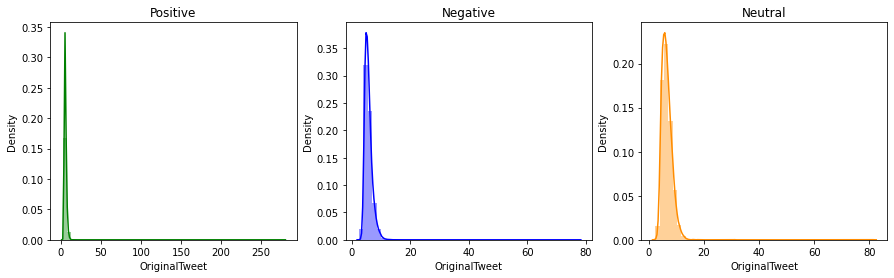

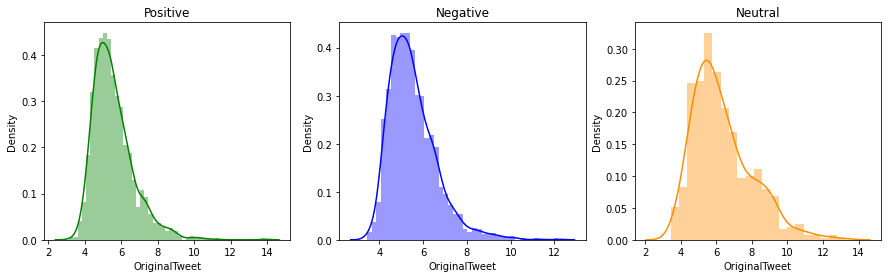

In [ ]:
def avg_word_len(df):
  fig,axes =plt.subplots(1,3,figsize=(15,4))
  df2 = df
  for i, s in enumerate(['Positive', 'Negative', 'Neutral']):
    
    words = df[df['sentiment_code'] == s]['OriginalTweet']
    words = words.str.split().apply(lambda sentence: [len(word) for word in sentence])
  
    word_length = words.map(lambda x: np.mean(x))
    sns.distplot(word_length,ax=axes[i],color=SENT_TO_COLOR[s])
    axes[i].set_title(s)

avg_word_len(df_train)
avg_word_len(df_test)


## Most Common stopwords for each sentiment
We are going to use the commons stopword dictionary offered by nltk to showcase the top 10 most used stopwords for each sentiment in the datasets.  They have thousands of occurrences so they could provide a lot of noise in the dataset. This may be enough of a motivation to consider removing them in the preprocessing phase.



Train set



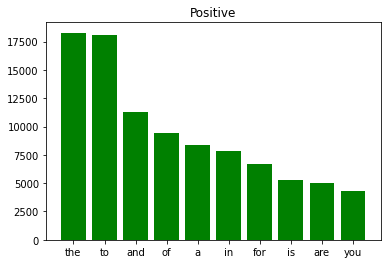

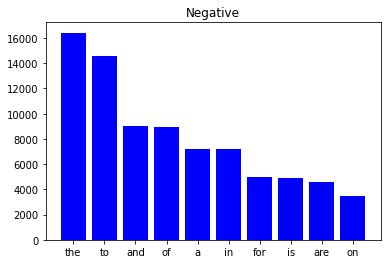

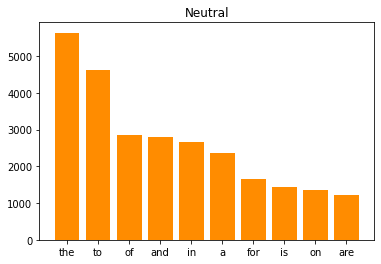


Test set



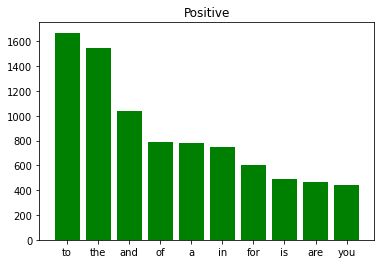

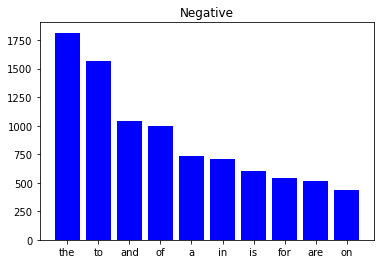

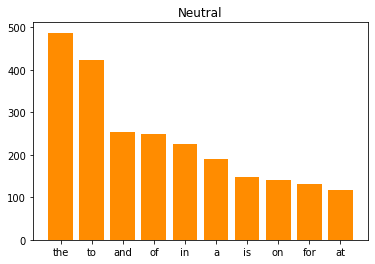

In [ ]:
STOP_WORDS = set(stopwords.words('english'))

def most_common_stopwords(sentiment, df):
  word_vecs = df[df['sentiment_code'] == sentiment]['OriginalTweet'].str.split()
  stops_count = defaultdict(int)
  for words in word_vecs:
    for word in words:
      if word in STOP_WORDS:
        stops_count[word] += 1
  
  stops_count = sorted(stops_count.items(), key= lambda x: x[1], reverse=True)
  #selecting the first 10
  stops_count = stops_count[:10]
  x, y = zip(*stops_count)
  plt.bar(x, y, color=SENT_TO_COLOR[sentiment])
  plt.title(sentiment)
  plt.show()

print("\nTrain set\n")
for sentiment in ['Positive', 'Negative', 'Neutral']:
  most_common_stopwords(sentiment, df_train)

print("\nTest set\n")
for sentiment in ['Positive', 'Negative', 'Neutral']:
  most_common_stopwords(sentiment, df_test)